In [19]:
from brian2 import *
from DynapSE import DynapSE
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PPGprocess import *

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90  

from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')
# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

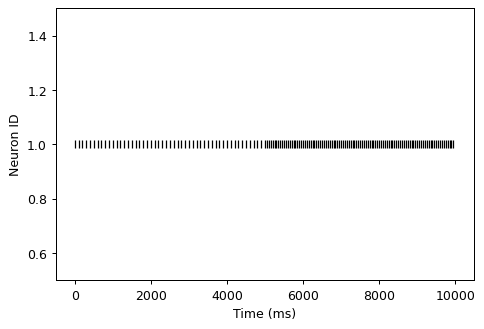

In [32]:
# Reinitialize the device
device.reinit()
device.activate()
defaultclock.dt = 20 * us



spikes=SpikeGenerator(10,5)#rate in hertz, note that I made Spike Genearator a function in PPG_processes
spikes=np.append(spikes,SpikeGenerator(20,5)) #pseudo, chirp signal, i think stacking them is good for now
#10 hertz and 20 hertz

spike_timing = np.where(spikes==1)[0] * ms # Timing of spikes
neuron_indices = np.zeros(len(spike_timing)) # ID of spike sources
input_spike_generator = SpikeGeneratorGroup(1, indices=neuron_indices, times=spike_timing, name='InpSpikeGenerator')    

if 1==1:
    plt.plot(spikes,'k|')
    plt.xlabel("Time (ms)")
    plt.ylabel("Neuron ID")
    plt.ylim(0.5, 1.5)
    plt.show()


In [33]:
network = Network() # Instantiate a Brian2 Network
chip = DynapSE(network) # Instantiate a Dynap-SE1 chip implementing neural and synaptic silicon dynamics

In [34]:
nf_pop=3
NeuInPop = 2
FNg, input_synapse, inh_synapse, int_synapse=[],[],[],[]
spikemon_FNg,statemon_FNg,statemon_input,statemon_int,statemon_inh,statemon_ampa,spikemon_input= [],[],[],[],[],[],[]

for i in range(nf_pop):
    FNg.append(chip.get_neurons(NeuInPop, 'Core_1'))

inh_n=chip.get_neurons(NeuInPop, 'Core_1')

############ Synapses #####################

#Input Spike train to inhibitor neuron
ampa_synapse = chip.add_connection(input_spike_generator,inh_n, synapse_type='AMPA') # Define a fast excitatory synapse
chip.connect(ampa_synapse, True)
ampa_synapse.weight = 500

#slow input connections
for i in range(nf_pop):
        input_synapse.append(chip.add_connection(input_spike_generator,FNg[i],synapse_type='NMDA'))
        input_synapse[i].connect(True)
        input_synapse[i].weight=100
        
syn_weight_list = [500, 500, 500,400,500,600,700,800]
#inhibitory neuron to filter nuerons
for i in range(nf_pop):
        inh_synapse.append(chip.add_connection(inh_n,FNg[i],synapse_type='GABA_B'))
        inh_synapse[i].connect(True)
        inh_synapse[i].weight=500
        
#connection from filtrons to each other
j=0
for i in range(nf_pop-1,-1,-1): 
       for k in range(i-1,-1,-1):
        int_synapse.append(chip.add_connection(FNg[i],FNg[k],synapse_type='GABA_B'))
        int_synapse[j].connect(True)
        int_synapse[j].weight= 1000
        j=j+1
        


2 neurons are allocated from Core_1.
2 neurons are allocated from Core_1.
2 neurons are allocated from Core_1.
2 neurons are allocated from Core_1.


In [35]:
for m in range(nf_pop):
        spikemon_FNg.append(SpikeMonitor(FNg[m]))
        statemon_FNg.append(StateMonitor(FNg[m], 'Imem', record=True))
        
for m in range(nf_pop):
    statemon_input.append( StateMonitor(input_synapse[m], 'I_syn_nmda', record=[0]))
    
for m in range(nf_pop):
    statemon_inh.append(StateMonitor(inh_synapse[m],'I_syn_gaba_b',record=[0]))
    
for m in range(j):
    statemon_int.append(StateMonitor(int_synapse[m],'I_syn_gaba_b',record=[0]))


spikemon_input = SpikeMonitor(input_spike_generator, name='mon_neuron_input')

statemon_ampa  = StateMonitor(ampa_synapse, 'I_syn_ampa', record=[0])
statemon_inh_n = StateMonitor(inh_n, 'Imem', record=[0])
spikemon_inh_n = SpikeMonitor(inh_n, name='inh_neuron_output')

In [36]:
network.add([input_spike_generator,FNg,inh_n,int_synapse,inh_synapse,input_synapse,ampa_synapse])
network.add([spikemon_FNg,statemon_FNg,statemon_input,statemon_inh_n,statemon_int,spikemon_input,statemon_ampa,spikemon_inh_n,statemon_inh])

In [37]:
# Simulation
network.run(10* 1000 * ms)

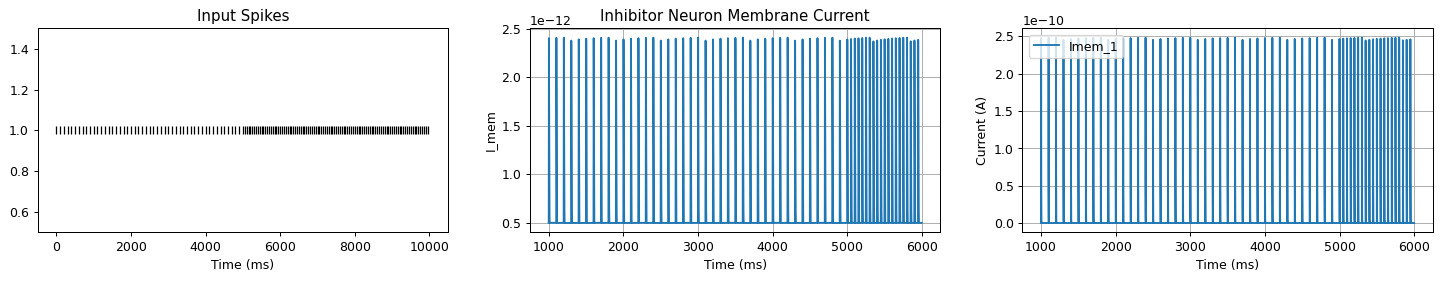

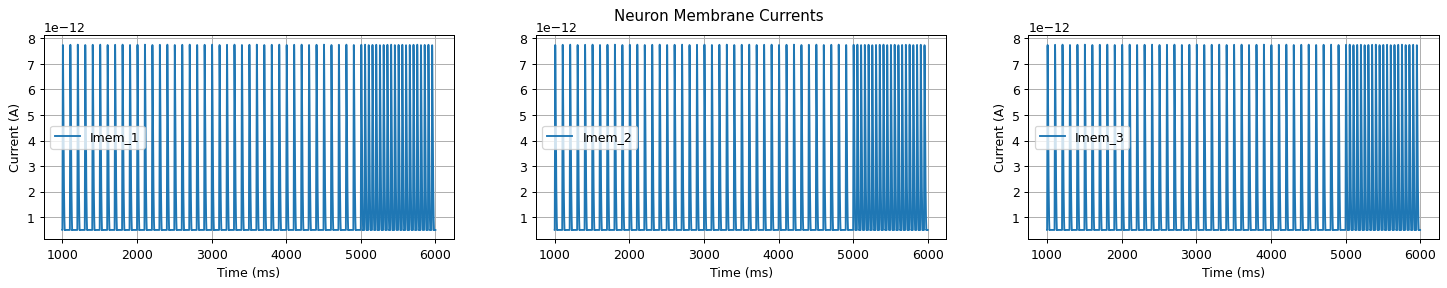

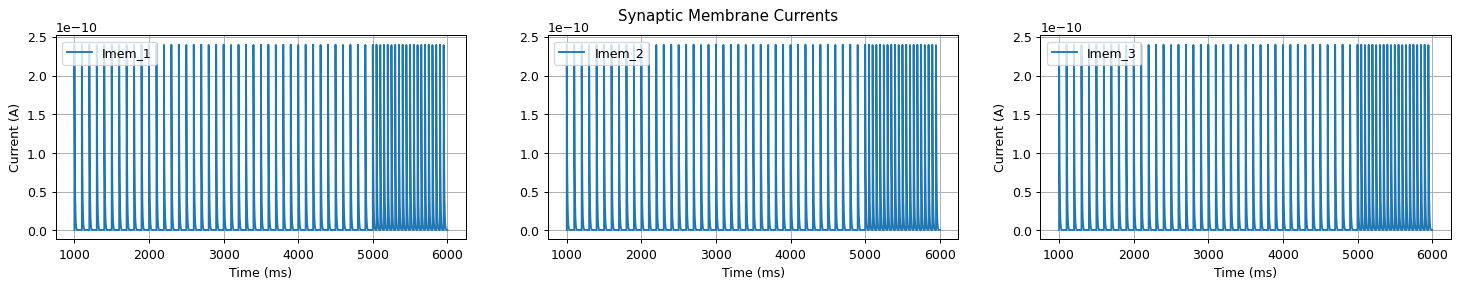

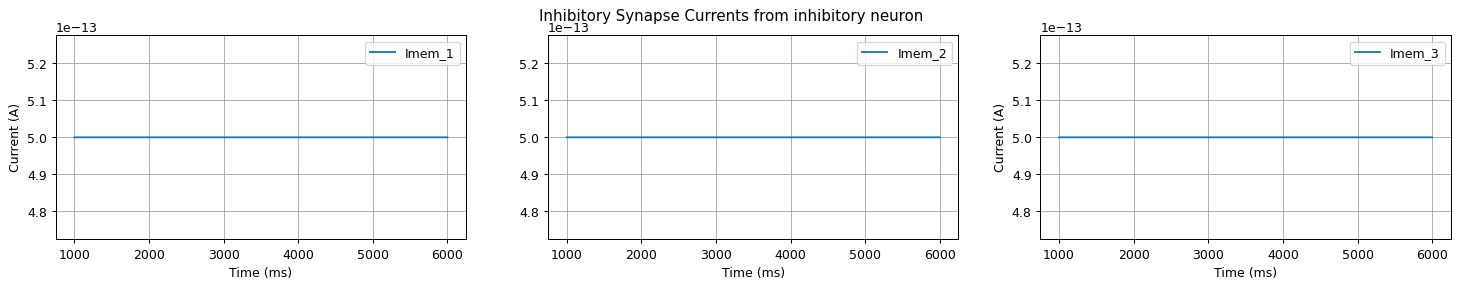

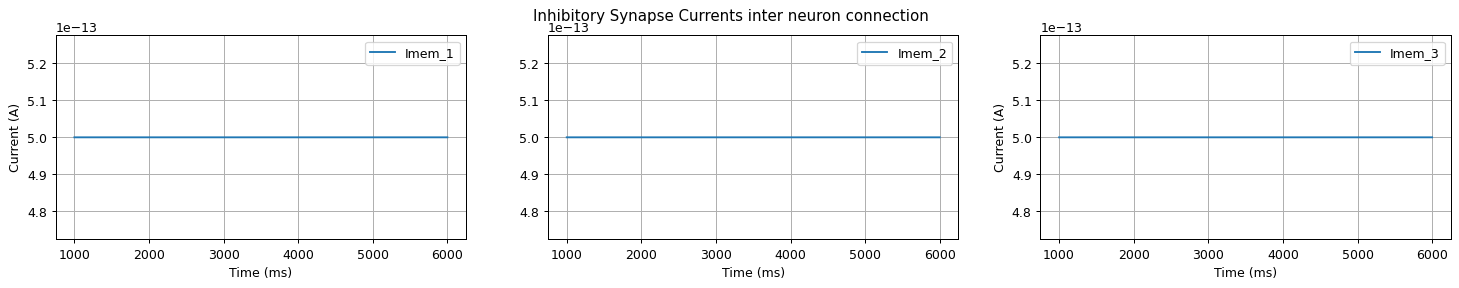

In [38]:
# Plotting

tstart = 1000 # ms 
tend   = 6000 # ms 
s = int(1*ms / defaultclock.dt)

fig1,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,3))

ax1.plot(spikes,'|k')
ax1.set_title('Input Spikes')
ax1.set_xlabel('Time (ms)')
ax1.axis(ymin=0.5,ymax=1.5)
ax1.grid(False)

ax2.plot(statemon_FNg[0].t[tstart*s:tend*s]/ms,statemon_inh_n.Imem[0][tstart*s:tend*s])
ax2.set_title('Inhibitor Neuron Membrane Current')
ax2.set_ylabel('I_mem')
ax2.set_xlabel('Time (ms)')
ax2.grid(True)

ax3.plot(statemon_FNg[0].t[tstart*s:tend*s]/ms, statemon_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1.5)
ax3.legend(['Imem_'+str(1)])
ax3.set_ylabel('Current (A)')
ax3.set_xlabel('Time (ms)')
ax3.grid(True)

fig2, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(20,3))
fig2.suptitle('Neuron Membrane Currents')

ax1.plot(statemon_FNg[0].t[tstart*s:tend*s]/ms, statemon_FNg[0].Imem[0][tstart*s:tend*s], linewidth=1.5)
ax1.legend(['Imem_'+str(1)])
ax1.set_ylabel('Current (A)')
ax1.set_xlabel('Time (ms)')
ax1.grid(True)

ax2.plot(statemon_FNg[1].t[tstart*s:tend*s]/ms, statemon_FNg[1].Imem[0][tstart*s:tend*s], linewidth=1.5)
ax2.legend(['Imem_'+str(2)])
ax2.set_xlabel('Time (ms)')
ax2.grid(True)

ax3.plot(statemon_FNg[2].t[tstart*s:tend*s]/ms, statemon_FNg[2].Imem[0][tstart*s:tend*s], linewidth=1.5)
ax3.legend(['Imem_'+str(3)])
ax3.set_ylabel('Current (A)')
ax3.set_xlabel('Time (ms)')
ax3.grid(True)

fig2, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(20,3))
fig2.suptitle('Synaptic Membrane Currents ') 

ax1.plot(statemon_FNg[0].t[tstart*s:tend*s]/ms, statemon_input[0].I_syn_nmda[0][tstart*s:tend*s], linewidth=1.5)
ax1.legend(['Imem_'+str(1)])
ax1.set_ylabel('Current (A)')
ax1.set_xlabel('Time (ms)')
ax1.grid(True)

ax2.plot(statemon_FNg[1].t[tstart*s:tend*s]/ms, statemon_input[1].I_syn_nmda[0][tstart*s:tend*s], linewidth=1.5)
ax2.legend(['Imem_'+str(2)])
ax2.set_xlabel('Time (ms)')
ax2.grid(True)

ax3.plot(statemon_FNg[2].t[tstart*s:tend*s]/ms, statemon_input[2].I_syn_nmda[0][tstart*s:tend*s], linewidth=1.5)
ax3.legend(['Imem_'+str(3)])
ax3.set_ylabel('Current (A)')
ax3.set_xlabel('Time (ms)')
ax3.grid(True)

fig3, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(20,3))
fig3.suptitle('Inhibitory Synapse Currents from inhibitory neuron')

ax1.plot(statemon_FNg[0].t[tstart*s:tend*s]/ms, statemon_inh[0].I_syn_gaba_b[0][tstart*s:tend*s], linewidth=1.5)
ax1.legend(['Imem_'+str(1)])
ax1.set_ylabel('Current (A)')
ax1.set_xlabel('Time (ms)')
ax1.grid(True)

ax2.plot(statemon_FNg[1].t[tstart*s:tend*s]/ms, statemon_inh[1].I_syn_gaba_b[0][tstart*s:tend*s], linewidth=1.5)
ax2.legend(['Imem_'+str(2)])
ax2.set_xlabel('Time (ms)')
ax2.grid(True)

ax3.plot(statemon_FNg[2].t[tstart*s:tend*s]/ms, statemon_inh[2].I_syn_gaba_b[0][tstart*s:tend*s], linewidth=1.5)
ax3.legend(['Imem_'+str(3)])
ax3.set_ylabel('Current (A)')
ax3.set_xlabel('Time (ms)')
ax3.grid(True)

fig4, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(20,3))
fig4.suptitle('Inhibitory Synapse Currents inter neuron connection')

ax1.plot(statemon_FNg[0].t[tstart*s:tend*s]/ms, statemon_int[0].I_syn_gaba_b[0][tstart*s:tend*s], linewidth=1.5)
ax1.legend(['Imem_'+str(1)])
ax1.set_ylabel('Current (A)')
ax1.set_xlabel('Time (ms)')
ax1.grid(True)

ax2.plot(statemon_FNg[1].t[tstart*s:tend*s]/ms, statemon_int[1].I_syn_gaba_b[0][tstart*s:tend*s], linewidth=1.5)
ax2.legend(['Imem_'+str(2)])
ax2.set_xlabel('Time (ms)')
ax2.grid(True)

ax3.plot(statemon_FNg[2].t[tstart*s:tend*s]/ms, statemon_int[2].I_syn_gaba_b[0][tstart*s:tend*s], linewidth=1.5)
ax3.legend(['Imem_'+str(3)])
ax3.set_ylabel('Current (A)')
ax3.set_xlabel('Time (ms)')
ax3.grid(True)














In [27]:
size(statemon_inh_n[0].Imem)

500000

In [28]:
print(statemon_inh_n.Imem[0])

[0.00000000e+00 9.40000000e-02 2.34575137e+01 ... 6.00000000e+02
 6.00000000e+02 6.00000000e+02] fA


In [18]:
print(j)


3
